<a href="https://colab.research.google.com/github/anhtruong1209/Deep-Learning/blob/master/HelmetProtected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libs
import torch 
import numpy as np
import matplotlib.pyplot as plt
import os 
from torchvision import transforms as T, datasets
from torchvision import models
from torch import  nn
import torch.nn.functional as F 
# import timm

In [2]:
torch.__version__

'1.9.0+cu102'

In [3]:
class Config:
    epochs = 50
    lr = 0.01
    batch_size = 128
    
    #model import from timm 
    # model_name = "tf_efficientnet_b0_ns"
    model_name = "resnet50"
    img_size = 64
    
    data_dir = "HelmetProtected_dataset"
    test = "test"
    train = "train"
    val = "val"
    
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
#Enable GPU    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("We have : {}".format(device))

We have : cpu


In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
cd drive/MyDrive/Colab\ Notebooks


/content/drive/MyDrive/Colab Notebooks


In [5]:
class_name = ['helmet','nohelmet']
class Utils:
    def show_image_orignal(image, label, get_denormalize=True):
        image = image.permute(1, 2, 0)
        mean = torch.FloatTensor([0.485, 0.456, 0.406])
        std = torch.FloatTensor([0.229, 0.224, 0.225])
        
        if get_denormalize == True:
            image = image * std + mean
            image = np.clip(image, 0, 1)
            plt.title(class_name[label])
            plt.imshow(image)
            plt.show()
        else:
            plt.title(class_name[label])
            plt.imshow(image)
            plt.show()

    def show_grid(image,title = None ):
        image = image.permute(1,2,0)
        mean = torch.FloatTensor([0.485, 0.456, 0.406])
        std = torch.FloatTensor([0.229, 0.224, 0.225])
        image = image*std + mean
        image = np.clip(image,0,1)
        
        plt.figure(figsize=[15, 15])
        plt.imshow(image)
        if title != None:
            plt.title(title) 


    def view_classify(image,ps,label):
    
        classes = np.array(class_name)

        ps = ps.cpu().data.numpy().squeeze()
        
        image = image.permute(1,2,0)
        mean = torch.FloatTensor([0.485, 0.456, 0.406])
        std = torch.FloatTensor([0.229, 0.224, 0.225])
        
    
        image = image*std + mean
        img = np.clip(image,0,1)
    
        fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
        ax1.imshow(img)
        ax1.set_title('Ground Truth : {}'.format(class_name[label]))
        ax1.axis('off')
        ax2.barh(classes, ps)
        ax2.set_aspect(0.1)
        ax2.set_yticks(classes)
        ax2.set_yticklabels(classes)
        ax2.set_title('Predicted Class')
        ax2.set_xlim(0, 1.1)

        plt.tight_layout()

        return None                   

In [7]:
train_transform = T.Compose([
    T.Resize(size = (Config.img_size, Config.img_size)),
    T.RandomRotation(degrees = (-20, +20)),
    T.ToTensor(), # (w,h,c) -> (c,h,w)
    T.Normalize(Config.mean, Config.std)
])

val_transform = T.Compose([
    T.Resize(size = (Config.img_size, Config.img_size)),
    T.ToTensor(), # (w,h,c) -> (c,h,w)
    T.Normalize(Config.mean, Config.std)
])

test_transform = T.Compose([
    T.Resize(size = (Config.img_size, Config.img_size)),
    T.ToTensor(), # (w,h,c) -> (c,h,w)
    T.Normalize(Config.mean, Config.std)
])

In [8]:
# train,val,test path

train_path = os.path.join(Config.data_dir, Config.train)
val_path = os.path.join(Config.data_dir, Config.val)
test_path = os.path.join(Config.data_dir, Config.test)

In [9]:
# train,val,test set

trainset = datasets.ImageFolder(train_path, transform = train_transform)
valset = datasets.ImageFolder(val_path, transform = val_transform)
testset = datasets.ImageFolder(test_path, transform = test_transform)

print("Length of trainset : {}".format(len(trainset)))
print("Length of valset : {}".format(len(valset)))
print("Length of testset : {}".format(len(testset)))


Length of trainset : 11991
Length of valset : 1066
Length of testset : 1216


{'helmet': 0, 'nohelmet': 1}


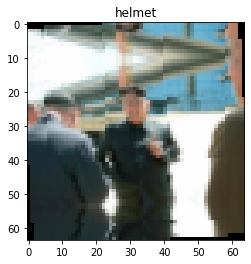

In [56]:
image, label = trainset[6000]
print(trainset.class_to_idx)
Utils.show_image_orignal(image, label)

In [10]:
#Load dataset into Batches 
from torch.utils.data import DataLoader
from torchvision.utils import make_grid


In [11]:
train_dataloader = DataLoader(trainset, batch_size=Config.batch_size,shuffle= True)
val_dataloader = DataLoader(valset, batch_size=Config.batch_size, shuffle= True)
test_dataloader = DataLoader(testset, batch_size=Config.batch_size, shuffle= True)


In [59]:
print("Length of trainloader : {}".format(len(train_dataloader)))
print("Length of valloader : {}".format(len(val_dataloader)))
print("Length of testloader : {}".format(len(test_dataloader)))

Length of trainloader : 94
Length of valloader : 9
Length of testloader : 10


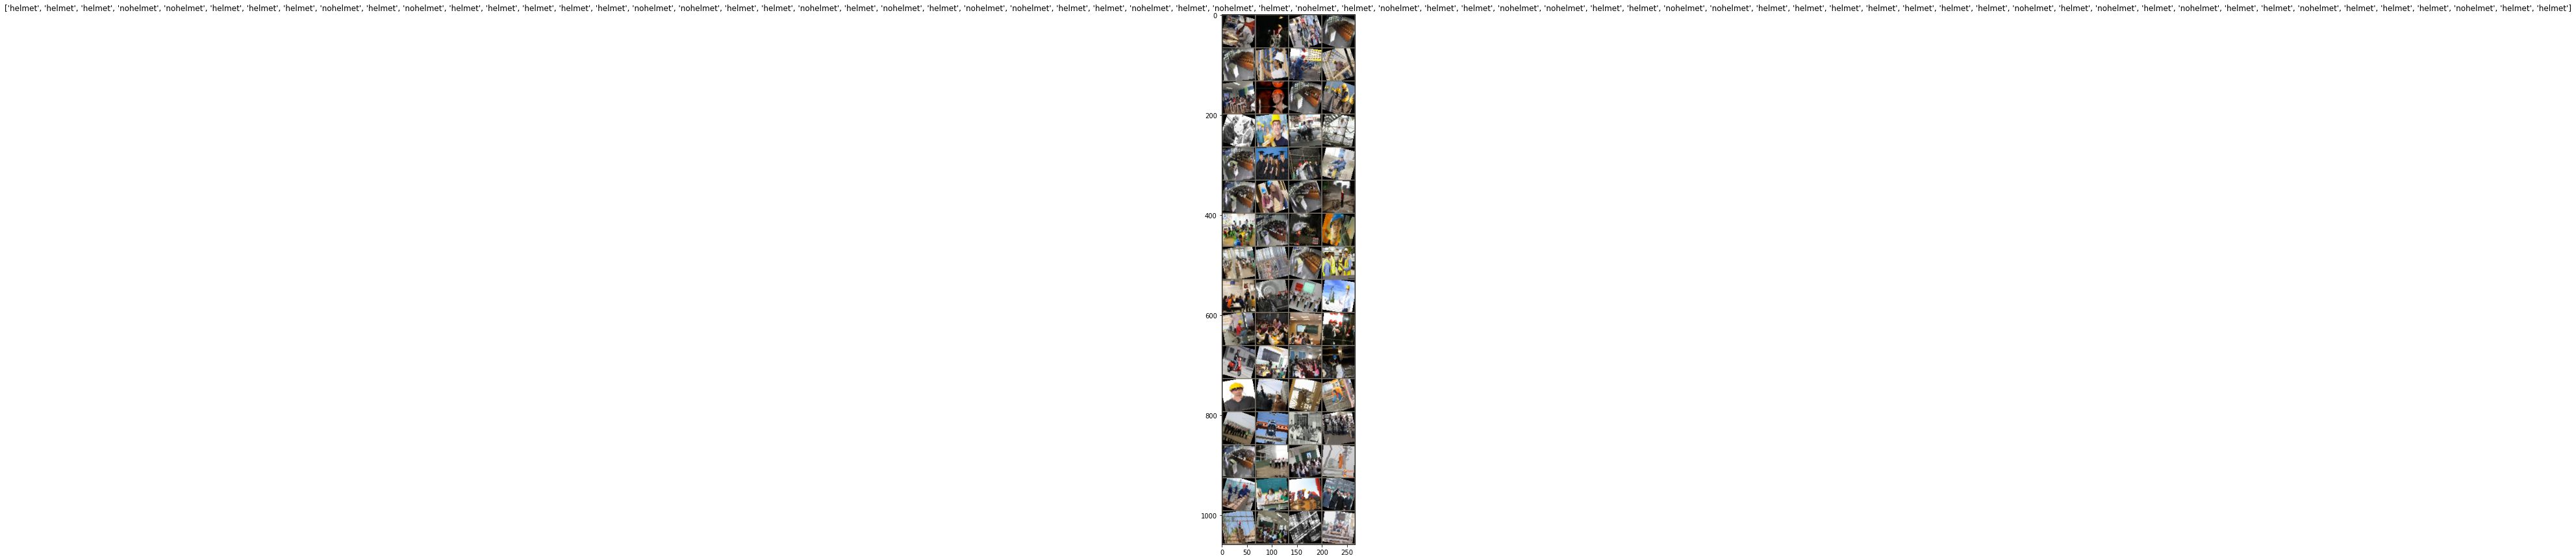

In [ ]:
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

out = make_grid(images, nrow= 4)
Utils.show_grid(out, title= [class_name[x] for x in labels])

In [12]:
def show_images(images, labels, preds):
    plt.figure(figsize=(15,15))
    for i, image in enumerate(images):
        plt.subplot(4,4,i + 1,xticks=[],yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229,0.224, 0.225])
        image = image * std + mean
        image = np.clip(image,0.,1.)
        plt.imshow(image)
        
        color ='green' if preds[i] == labels[i] else 'red'
        plt.xlabel(f'{class_name[int(labels[i].numpy())]}',fontsize=14)
        plt.ylabel(f'{class_name[int(preds[i].numpy())]}', color = color, fontsize=20)
    plt.tight_layout()
    plt.show()


ValueError: ignored

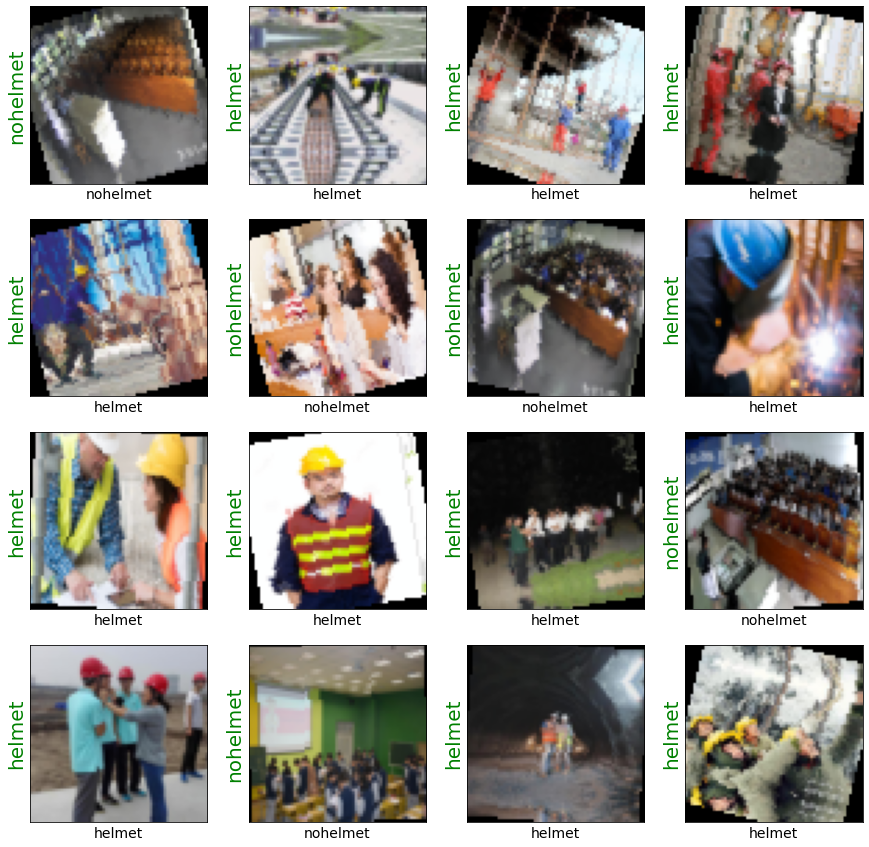

In [ ]:
images, labels = next(iter(train_dataloader))
show_images(images, labels, labels)

In [ ]:
#Fine Tuning Efficient Model 
!pip install timm

In [13]:
model = models.resnet50()
model

# Custom just change classifier and put output before features and train it

model.fc = nn.Linear(in_features = 2048, out_features =2 )

In [14]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
ls

In [ ]:
!wget https://download.pytorch.org/models/resnet50-0676ba61.pth

In [15]:
from torchsummary import  summary
#move model to device
model.to(device)
summary(model, input_size = (3,Config.img_size, Config.img_size))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]           4,096
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]          16,384
      BatchNorm2d-12          [-1, 256, 16, 16]             512
           Conv2d-13          [-1, 256, 16, 16]          16,384
      BatchNorm2d-14          [-1, 256,

In [16]:
# Build a Simple Trainer
from tqdm import tqdm
# use support cuda for training
torch.backends.cudnn.benchmark = True


In [17]:
def accuracy(y_pred,labels):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1) 
    equals = top_class == labels.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [18]:
train_loss_list = []
train_acc_list =[]
valid_loss_list =[]
valid_acc_list= []    

In [19]:
class HelmetTrainer():

    def __init__(self,criterion = None,optimizer = None,schedular = None):
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
    
    def train_batch_loop(self,model,trainloader):
        
        train_loss = 0.0
        train_acc = 0.0
      
        for images,labels in tqdm(trainloader): 
            
            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(logits,labels)
          
            
        return train_loss / len(trainloader), train_acc / len(trainloader) *100

    
    def valid_batch_loop(self,model,validloader):
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm(validloader):
            
            # move the data to CPU
            images = images.to(device) 
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(logits,labels)
  
        return valid_loss / len(validloader), valid_acc / len(validloader)*100
            
        
    def fit(self,model,trainloader,validloader,epochs):
        
        valid_min_loss = np.Inf 
        
        for i in range(epochs):
            
            model.train() # this turn on dropout
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader) ###
            # add to list
            train_loss_list.append(avg_train_loss)
            train_acc_list.append(avg_train_acc)  

            model.eval()  # this turns off the dropout lapyer and batch norm
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader) ###
            # add to list
            valid_loss_list.append(avg_valid_loss)
            valid_acc_list.append(avg_valid_acc)
            if avg_valid_loss <= valid_min_loss :
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                print()
                print("="*30)
                torch.save(model.state_dict(),'HelmetModelResNet50-2.pt')
                valid_min_loss = avg_valid_loss # reset

            print()    
            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))

In [20]:
#loss
criterion = nn.CrossEntropyLoss()
#optimizer
optimizer = torch.optim.Adam(model.parameters(),lr = Config.lr)
#schedular 
schedular = None
print("-----Start training-----")
trainer = HelmetTrainer(criterion,optimizer, schedular)


-----Start training-----


In [ ]:
trainer.fit(model,train_dataloader,val_dataloader,epochs = Config.epochs)

100%|██████████| 9/9 [04:40<00:00, 31.13s/it]


Valid_loss decreased inf --> 0.6722312768300375



  0%|          | 0/94 [00:00<?, ?it/s]


Epoch : 1 Train Loss : 0.988455 Train Acc : 67.416199
Epoch : 1 Valid Loss : 0.672231 Valid Acc : 59.490742


  0%|          | 0/94 [00:00<?, ?it/s]


Epoch : 2 Train Loss : 0.537331 Train Acc : 79.080208
Epoch : 2 Valid Loss : 0.817802 Valid Acc : 59.924770


100%|██████████| 9/9 [00:51<00:00,  5.77s/it]


Valid_loss decreased 0.6722312768300375 --> 0.5851412216822306



  0%|          | 0/94 [00:00<?, ?it/s]


Epoch : 3 Train Loss : 0.388893 Train Acc : 83.825417
Epoch : 3 Valid Loss : 0.585141 Valid Acc : 72.280098


  0%|          | 0/94 [00:00<?, ?it/s]


Epoch : 4 Train Loss : 0.331472 Train Acc : 85.624062
Epoch : 4 Valid Loss : 0.980225 Valid Acc : 64.343582


  0%|          | 0/94 [00:00<?, ?it/s]


Epoch : 5 Train Loss : 0.307552 Train Acc : 86.556351
Epoch : 5 Valid Loss : 0.837374 Valid Acc : 66.534393


  0%|          | 0/94 [00:00<?, ?it/s]


Epoch : 6 Train Loss : 0.297287 Train Acc : 87.333679
Epoch : 6 Valid Loss : 0.716726 Valid Acc : 71.155754


100%|██████████| 9/9 [00:54<00:00,  6.09s/it]


Valid_loss decreased 0.5851412216822306 --> 0.5584893425305685



  0%|          | 0/94 [00:00<?, ?it/s]


Epoch : 7 Train Loss : 0.285015 Train Acc : 88.142822
Epoch : 7 Valid Loss : 0.558489 Valid Acc : 74.851189


  0%|          | 0/94 [00:00<?, ?it/s]


Epoch : 8 Train Loss : 0.265273 Train Acc : 88.824341
Epoch : 8 Valid Loss : 0.713131 Valid Acc : 71.482307


  0%|          | 0/94 [00:00<?, ?it/s]


Epoch : 9 Train Loss : 0.257609 Train Acc : 89.339157
Epoch : 9 Valid Loss : 0.687105 Valid Acc : 71.126816


 49%|████▉     | 46/94 [08:56<09:22, 11.73s/it]

In [ ]:
#load model trained

model.load_state_dict(torch.load('HelmetModelResNet50-2.pt', map_location= device))
model.eval() # this turns off the dropout lapyer and batch norm

avg_test_loss, avg_test_acc= trainer.valid_batch_loop(model, test_dataloader)

print("Test Acc : {}".format(avg_test_acc))
print("Test Loss : {}".format(avg_test_loss))
avg_valid_loss, avg_valid_acc= trainer.valid_batch_loop(model, val_dataloader)

print("Valid Acc : {}".format(avg_valid_acc))
print("Valid Loss : {}".format(avg_valid_loss))

  0%|          | 0/9 [00:00<?, ?it/s]

Test Acc : 83.828125
Test Loss : 0.5233694165945053


100%|██████████| 9/9 [00:24<00:00,  2.76s/it]

Valid Acc : 80.63409423828125
Valid Loss : 0.5698648078574075


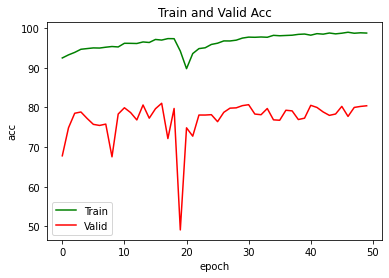

In [ ]:
plt.plot(train_acc_list,'-g')
plt.plot(valid_acc_list,'r')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['Train','Valid'])
plt.title('Train and Valid Acc')
plt.show()

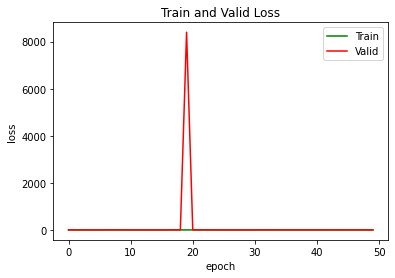

In [ ]:
plt.plot(train_loss_list,'-g')
plt.plot(valid_loss_list,'r')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Train and Valid Loss')
plt.show()

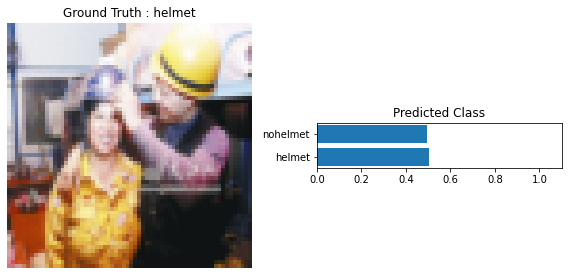

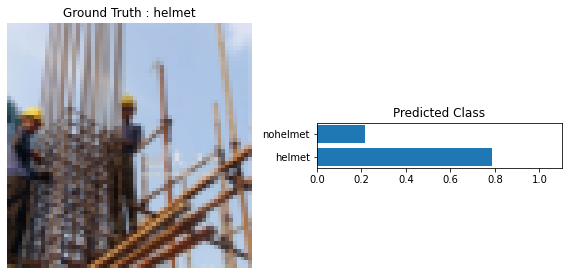

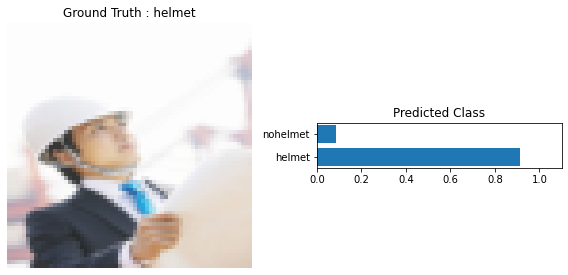

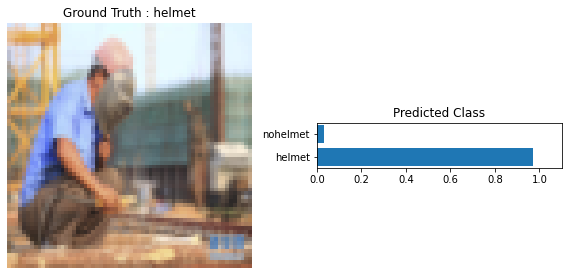

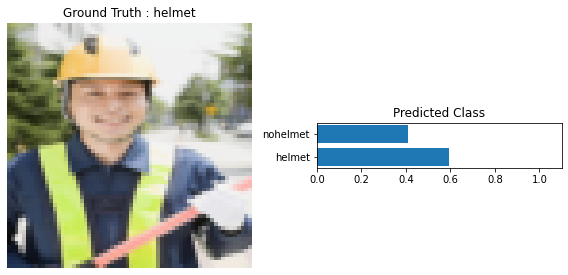

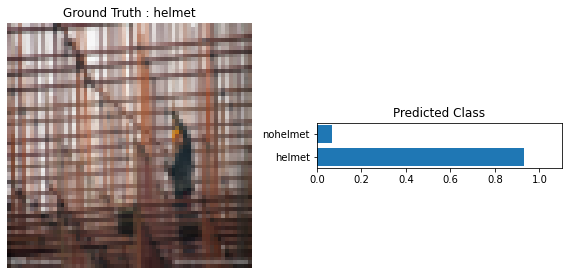

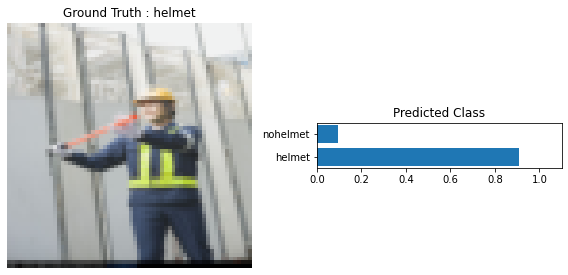

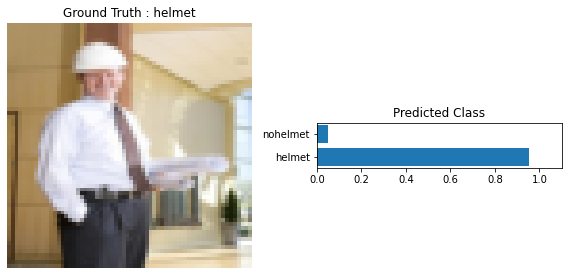

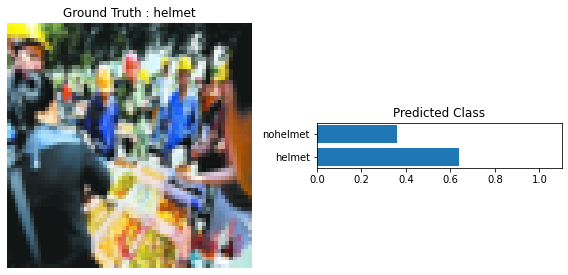

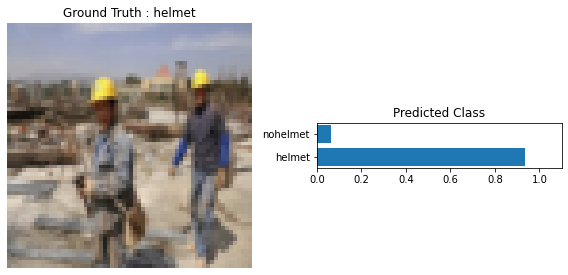

In [ ]:
for i in range(110,120,1): #show 10 view_classify
    
    images , labels = testset[i]
    logits = model(images.to(device).unsqueeze(0)) # (3,224,224) -> (1,3,224,224) and move image to device 
    ps = F.softmax(logits, dim= 1)
    Utils.view_classify(images, ps, labels)

In [ ]:

def show_preds():
    model.eval()
    images, labels = next(iter(test_dataloader))
    print(type(images))
    outputs = model(images.to(device))
    
    _,preds = torch.max(outputs,1)

    print(type(preds))
    preds = preds.squeeze().detach().cpu()
    show_images(images, labels, preds)

<class 'torch.Tensor'>
<class 'torch.Tensor'>


ValueError: ignored

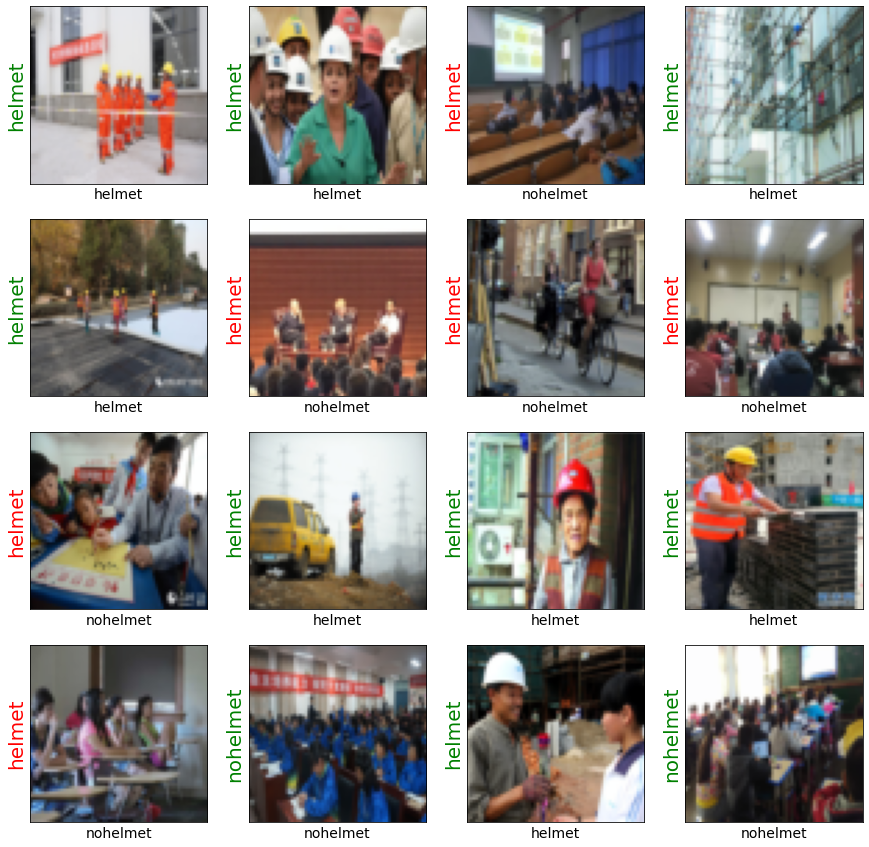

In [ ]:
show_preds()